In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.metrics import pairwise_distances
plt.rcParams['figure.figsize'] = (11, 5)

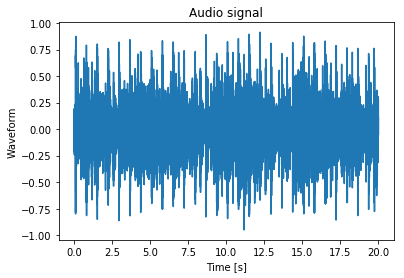

In [2]:
path = "Data/genres_original/pop/pop.00027.wav"
hop_length = 1024
sample, sr = librosa.load(path, duration=20)
sample_comp, sr = librosa.load(path, offset=10) 
duration = np.arange(len(sample)) / sr

plt.plot(duration, sample)
plt.title("Audio signal")
plt.ylabel("Waveform")
plt.xlabel("Time [s]")
plt.show()

ipd.Audio(sample, rate=sr)
ipd.Audio(sample_comp, rate=sr)

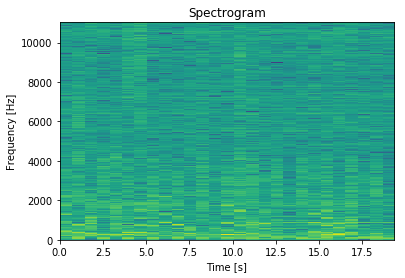

In [3]:
songTempo, beats = librosa.beat.beat_track(y=sample, sr=sr)

# %% Calculate beat duration
beatDurationSec = 60 / songTempo
beatDurationSample = int(beatDurationSec * sr)

# %% target spectrogram
spectrogram, frequencies, times, im = plt.specgram(
    sample,
    Fs=sr,
    NFFT=int(beatDurationSample),
    noverlap=(64),
    mode="magnitude",
)
plt.title("Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()

In [4]:
mfcc = librosa.feature.mfcc(y=sample, sr=sr, hop_length=hop_length, n_mfcc=13)
mfcc_comp = librosa.feature.mfcc(y=sample_comp, sr=sr, hop_length=hop_length, n_mfcc=13)

#the mean normalized mfcc to reduce signal to noise ratio
mfcc -= (np.mean(mfcc, axis=0) + 1e-8) 
mfcc_comp -= (np.mean(mfcc_comp, axis=0) + 1e-8)

mfcc = librosa.feature.delta(mfcc)
mfcc_comp = librosa.feature.delta(mfcc_comp)

mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc, n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0)
mfcc_comp = librosa.feature.inverse.mfcc_to_mel(mfcc_comp, n_mels=128, dct_type=2, norm='ortho', ref=1.0, lifter=0)

#chroma features
# chroma_ref = librosa.feature.chroma_cqt(y=sample, sr=sr, hop_length=hop_length)
# chroma_comp = librosa.feature.chroma_cqt(y=sample_comp, sr=sr, hop_length=hop_length)

# #Use time-delay embedding to get a cleaner recurrence matrix
# x_ref = librosa.feature.stack_memory(chroma_ref, n_steps=10, delay=3)
# x_comp = librosa.feature.stack_memory(chroma_comp, n_steps=10, delay=3)

/Users/pianistprogrammer/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/pianistprogrammer/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


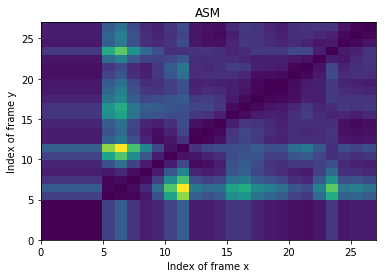

In [5]:
binsAmount = len(beats)
asm = np.zeros((binsAmount, binsAmount))


def euclidianDistance(oneBin, secondBin):
    return np.sum(np.square(oneBin - secondBin)), "Euclidian Distance"


def cosineDistance(oneBin, secondBin):
    return (
        1
        - np.sum(np.square(oneBin * secondBin))
        / (np.sqrt(np.sum(np.square(oneBin))) * np.sqrt(sum(np.square(secondBin)))),
        "Cosine Distance",
    )


def kullbackLeibler(oneBin, secondBin):
    return np.sum(oneBin * np.log(oneBin / secondBin)), "Kullback-Leiber"


for x in range(binsAmount):
    thisBin = mfcc[:, x]
    for y in range(binsAmount):
        comparedBin = mfcc[:, y]
        asm[x, y], method = euclidianDistance(thisBin, comparedBin)
        #asm[x, y], method = cosineDistance(thisBin, comparedBin)
        # asm[x, y], method = kullbackLeibler(thisBin, comparedBin)

# asm = librosa.segment.cross_similarity(mfcc, mfcc_comp, metric='cosine', mode='distance')

plt.pcolormesh(asm)
plt.title("ASM")
plt.xlabel("Index of frame x")
plt.ylabel("Index of frame y")
plt.show()

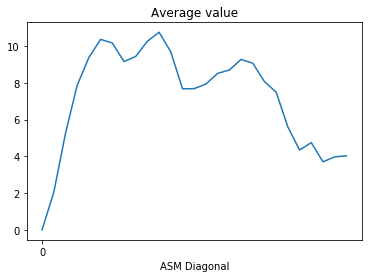

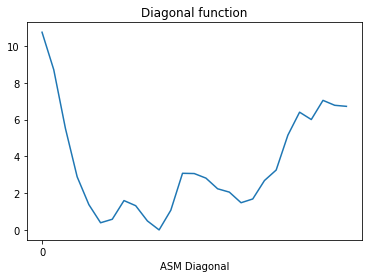

In [6]:
matrixLength = len(asm)
d = np.zeros(matrixLength)
for i in range(matrixLength):
    d[i] = np.average(np.diag(asm, i))

plt.title("Average value")
plt.xlabel("ASM Diagonal")
plt.plot(d)
plt.xticks(range(0, len(d), 32))
plt.show()

# %% Calculate second function d
for i in range(matrixLength):
    d[i] = -d[i] + np.max(np.abs(d))

plt.title("Diagonal function")
plt.xlabel("ASM Diagonal")
plt.plot(d)
plt.xticks(range(0, len(d), 32))
plt.show()

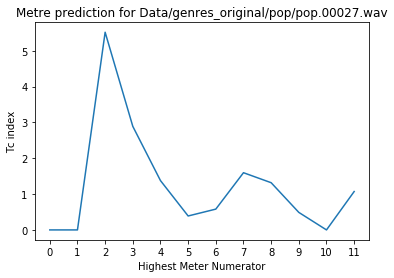

Time signature is: 2


In [7]:
highestMeterNumerator = 12
lt = int(len(asm) / highestMeterNumerator)
t = np.zeros(highestMeterNumerator)
for c in range(2, highestMeterNumerator, 1):
    for p in range(1, lt, 1):
        t[c] += (d[p * c]) / (1 - ((p - 1) / lt))

t[0] = 0
t[1] = 0
plt.plot(t)
plt.xlabel("Highest Meter Numerator")
plt.ylabel("Tc index")
plt.title(f"Metre prediction for {path}")
plt.xticks(range(0, len(t), 1))
plt.show()

# %% detect metre
metre = np.argmax(t)
print('Time signature is:', metre)